In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import warnings
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hp

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore")


In [3]:
from CoPhaser import CoPhaser
from CoPhaser import plotting

## Load Data and Trained Model

In [ ]:
path = '/data/cgobet/2026_06_01_spatial_exploratory/data/'
adata = sc.read_h5ad(os.path.join(path, 'xenium_ovary_both.h5ad'))

model = CoPhaser.load(os.path.join(path, "cophaser_ovary_model_both_full.pth"))
model.load_anndata(adata, layer_to_use="counts") 

### Extract Model Outputs

In [ ]:
generative_outputs, space_outputs = model.get_outputs()
thetas = space_outputs["theta"].detach().numpy()

# Store key outputs in AnnData
adata.obs["inferred_theta"] = thetas
adata.obs['cycling_prob'] = space_outputs["b_z"].detach().numpy()
adata.obs['cell_cycle_status'] = np.where(adata.obs['cycling_prob'] < 0.5, 'non-cycling', 'cycling')
adata.obs['library_size'] = adata.obs['total_counts']
adata.obsm['X_z'] = space_outputs['z'].detach().numpy()
cycling_cells = space_outputs["b_z"] > 0.5
adata.obsm['X_z'] = space_outputs['z'].detach().numpy()

### Organize Generative Outputs

In [31]:
def add_theta(df, theta):
    df["inferred_theta"] = theta
    return df

# Create DataFrames for different model components

df_mean = pd.DataFrame(
    generative_outputs["px_rate"].detach().numpy(), columns=model.context_genes
)
df_mean = add_theta(df_mean, thetas)
df_rhythmic = pd.DataFrame(
    generative_outputs["F"].detach().numpy(), columns=model.context_genes
)
df_rhythmic = add_theta(df_rhythmic, thetas)
df_z = pd.DataFrame(
    generative_outputs["Z"].detach().numpy(), columns=model.context_genes
)
df_z = add_theta(df_z, thetas)


### Visualize Cell Cycle Phase Distribution by Dataset

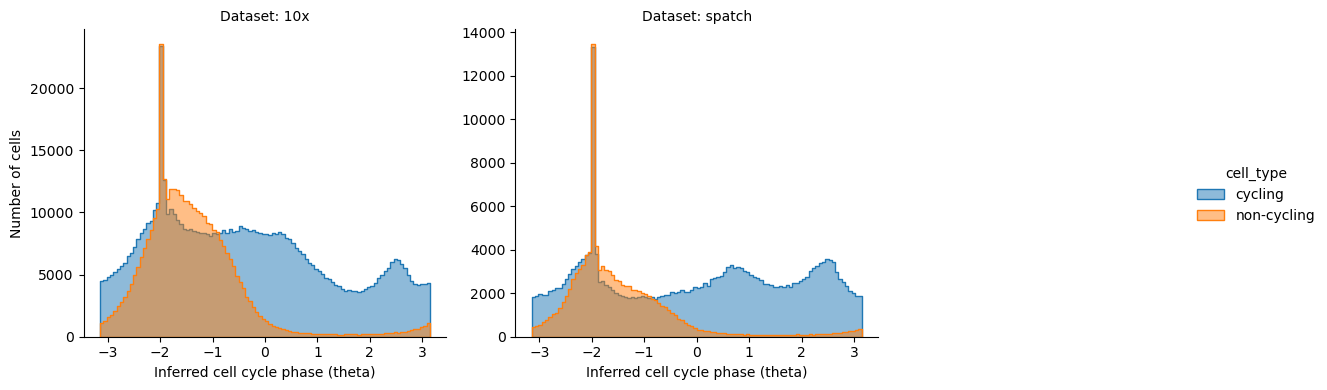

In [32]:

plot_df = pd.DataFrame({
    'theta': thetas,
    'dataset': adata.obs['dataset'].values,
    'cell_type': ['cycling' if c else 'non-cycling' for c in cycling_cells]
})

g = sns.FacetGrid(plot_df, col="dataset", hue="cell_type", 
                  col_wrap=3, height=4, sharey=False)
g.map(sns.histplot, "theta", bins=100, element="step", alpha=0.5)

g.add_legend()
g.set_axis_labels("Inferred cell cycle phase (theta)", "Number of cells")
g.set_titles("Dataset: {col_name}")
plt.tight_layout()
plt.show()

### Plot Key Rhythmic Gene Expression Patterns

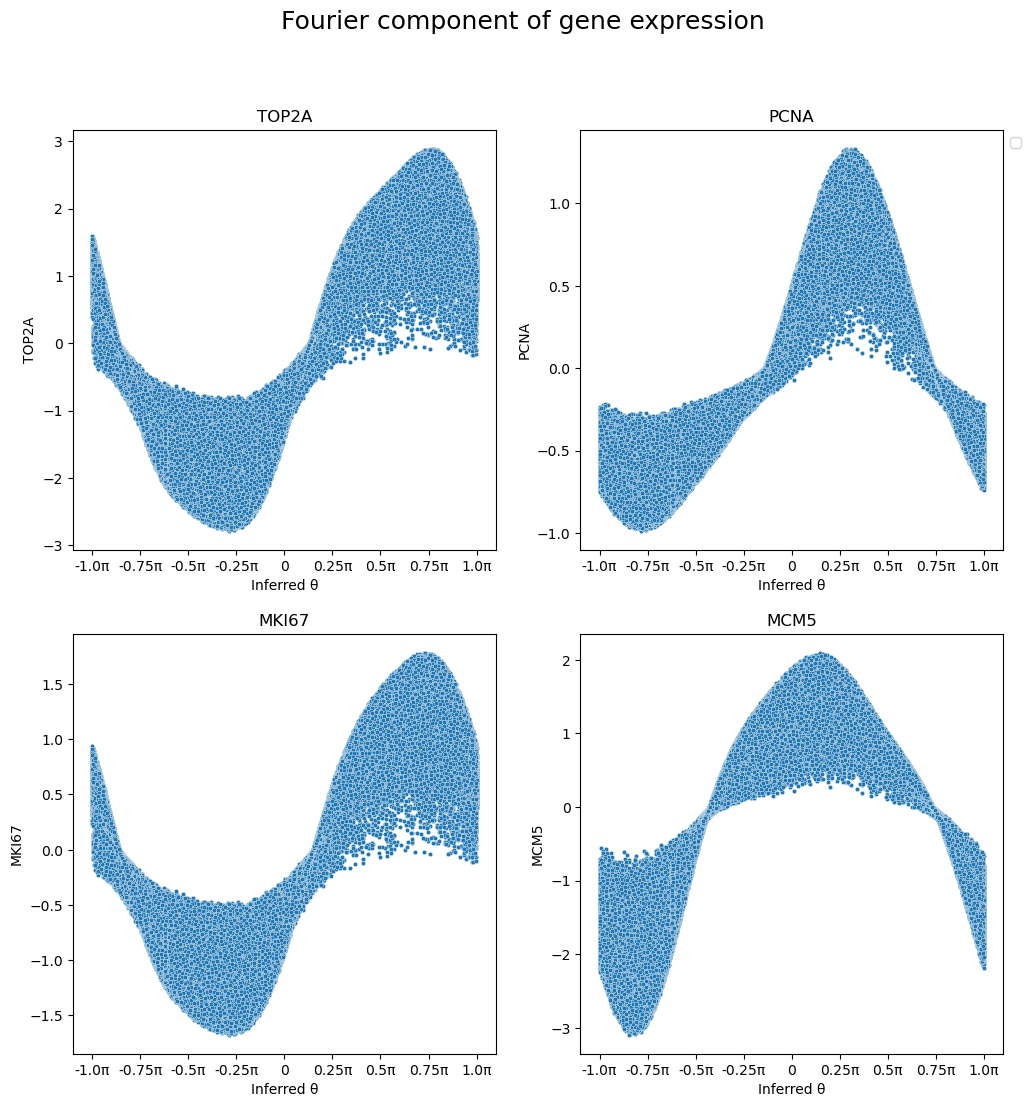

In [33]:
plotting.plot_model_decoded_space(
    df_rhythmic.loc[cycling_cells.detach().numpy()],
    gene_to_upper=True,
    title="Fourier component of gene expression",
    genes=["TOP2A", "PCNA", "MKI67",'MCM5']
)

### Visualize Fourier Coefficients

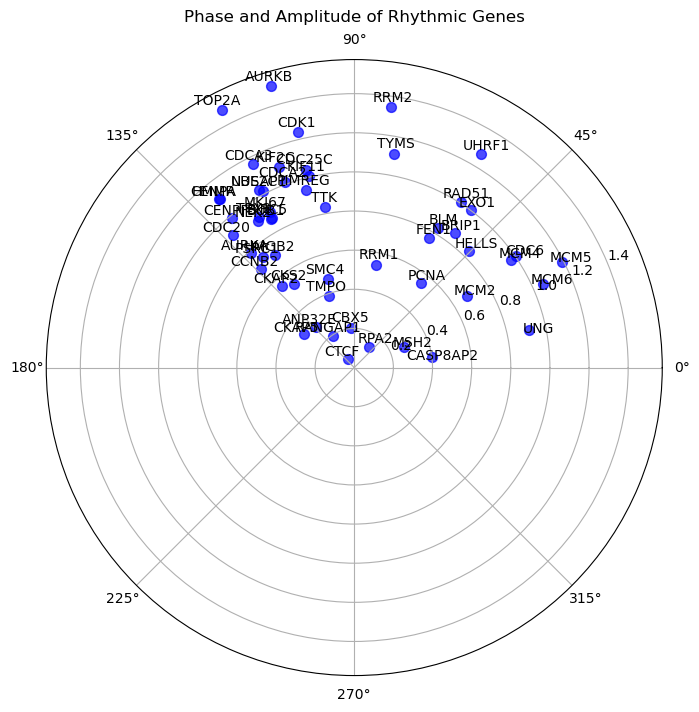

In [17]:
model.plot_fourier_coefficients()

### Cell Size and Library Size Evolution Across Cell Cycle

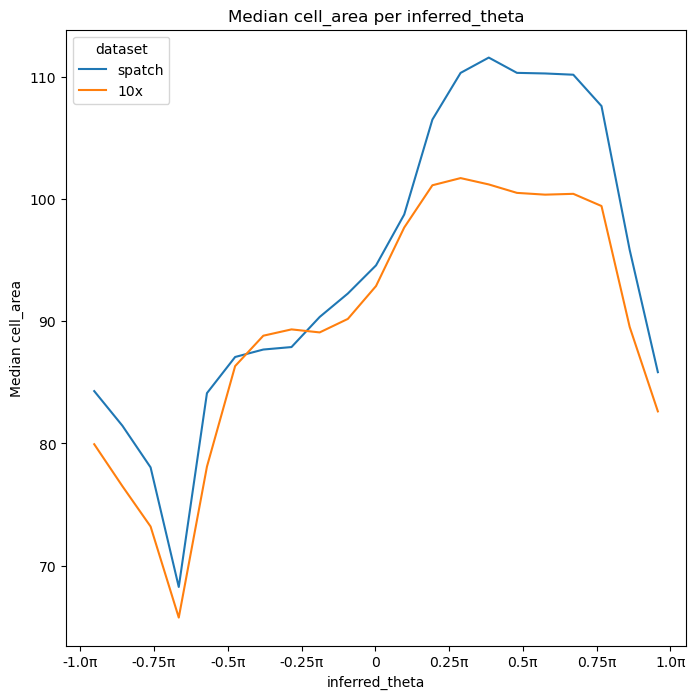

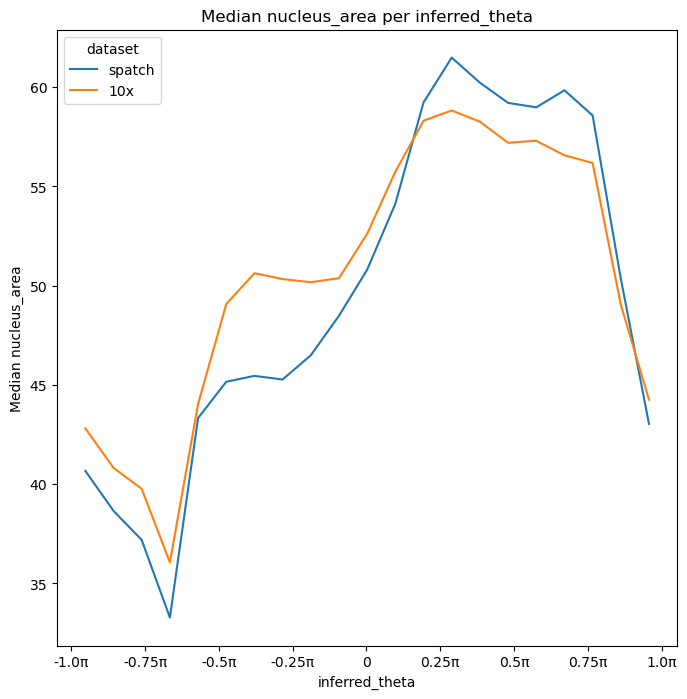

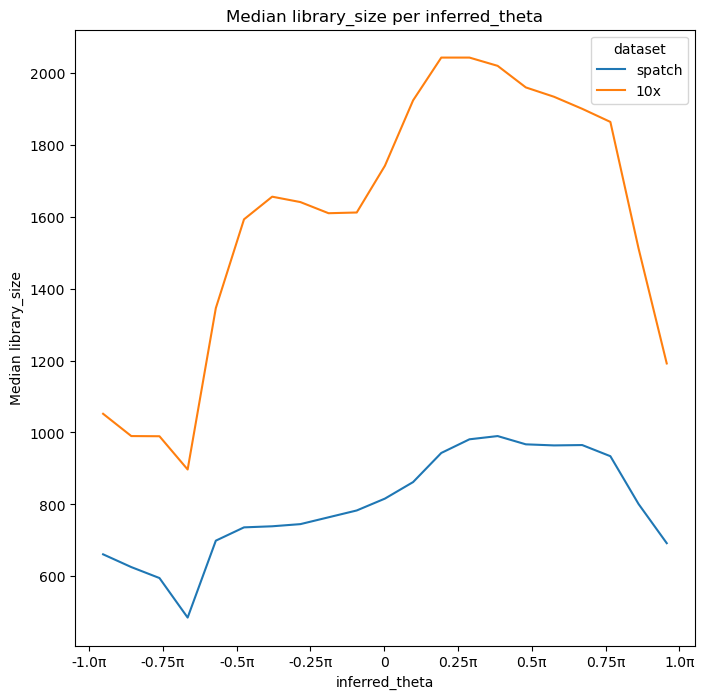

In [34]:
plotting.plot_smoothed_size_evolution(adata, "inferred_theta",counts_sum_field='cell_area', hue='dataset')
plt.show()

plotting.plot_smoothed_size_evolution(adata, "inferred_theta",counts_sum_field='nucleus_area', hue='dataset')
plt.show()

plotting.plot_smoothed_size_evolution(adata, "inferred_theta",counts_sum_field='library_size', hue='dataset')
plt.show()


### Overall Cell Cycle Phase Visualization

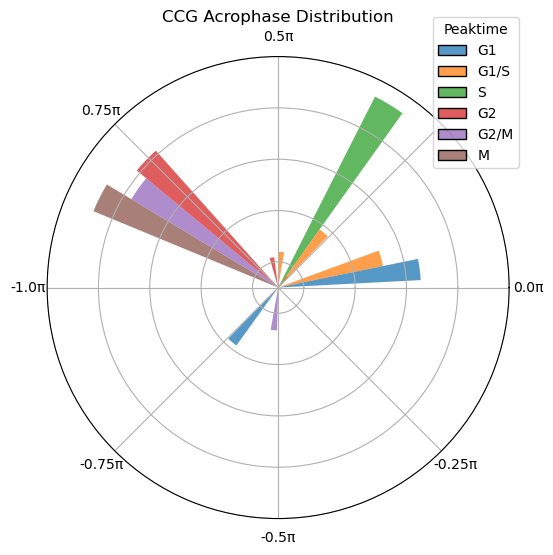

In [21]:
plotting.plot_cell_cycle(df_rhythmic) 

### Assign Cell Cycle Phases
 
 Manual phase assignment based on theta values, polar histogram gene profiles and total transcript counts:
 - **G0**: Non-cycling cells
 - **G1**: -0.9π to 0
 - **G1/S**: 0 to 0.25π
 - **S**: 0.25π to 0.7π
 - **G2/M**: 0.7π to π and -π to -0.9π


In [ ]:

categories = np.empty(thetas.shape, dtype=object)
    
pi = np.pi

# Define phase boundaries
mask_g2m = (thetas > 0.7 * pi) | (thetas < -0.9 * pi)
categories[mask_g2m] = 'G2/M'

mask_g1 = (thetas > -0.9 * pi) & (thetas < 0 * pi)
categories[mask_g1] = 'G1'

mask_g1s = (thetas > 0 * pi) & (thetas < 0.25 * pi)
categories[mask_g1s] = 'G1/S'

mask_s = (thetas > 0.25 * pi) & (thetas < 0.7 * pi)
categories[mask_s] = 'S'

# Assign non-cycling cells to G0
categories[~cycling_cells.detach().numpy()] = 'G0'

# Store in AnnData with ordered categories

adata.obs['cell_cycle_phase'] = pd.Categorical(
    categories,
    categories=['G0', 'G1', 'G1/S', 'S', 'G2/M'],
    ordered=True
)

# Create simplified cell cycle status (G0/G1 vs Proliferative)
adata.obs['cell_cycle_status_2'] = np.where(
    adata.obs['cell_cycle_phase'].isin(['G0', 'G1']),
    'G0/G1',
    'Proliferative'
)

print("\nCell cycle phase distribution:")
print(adata.obs['cell_cycle_phase'].value_counts())

### Batch Correction with Harmony


In [ ]:
data_mat = adata.obsm['X_z'].T 
meta_data = adata.obs[['dataset']]
ho = hp.run_harmony(data_mat, meta_data, 'dataset')

adata.obsm['X_z_harmony'] = ho.Z_corr 

2026-02-03 11:41:03,889 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-03 11:41:03,891 - harmonypy - INFO -   Parameters:
2026-02-03 11:41:03,891 - harmonypy - INFO -     max_iter_harmony: 10
2026-02-03 11:41:03,892 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-03 11:41:03,893 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-03 11:41:03,893 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-03 11:41:03,893 - harmonypy - INFO -     nclust: 100
2026-02-03 11:41:03,894 - harmonypy - INFO -     block_size: 0.05
2026-02-03 11:41:03,894 - harmonypy - INFO -     lamb: [1. 1.]
2026-02-03 11:41:03,895 - harmonypy - INFO -     theta: [2. 2.]
2026-02-03 11:41:03,896 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-03 11:41:03,896 - harmonypy - INFO -     verbose: True
2026-02-03 11:41:03,896 - harmonypy - INFO -     random_state: 0
2026-02-03 11:41:03,897 - harmonypy - INFO -   Data: 10 PCs × 1434619 cells
2026-02-03 11:41:03,897 - harmonypy - IN

2026-02-03 11:41:11,993 - harmonypy - INFO - KMeans initialization complete.
2026-02-03 11:41:12,248 - harmonypy - INFO - Iteration 1 of 10
2026-02-03 11:41:36,253 - harmonypy - INFO - Iteration 2 of 10
2026-02-03 11:42:00,763 - harmonypy - INFO - Iteration 3 of 10
2026-02-03 11:42:23,051 - harmonypy - INFO - Iteration 4 of 10
2026-02-03 11:42:46,257 - harmonypy - INFO - Iteration 5 of 10
2026-02-03 11:43:09,606 - harmonypy - INFO - Iteration 6 of 10
2026-02-03 11:43:33,483 - harmonypy - INFO - Converged after 6 iterations


### Clustering and UMAP

In [25]:
sc.pp.neighbors(adata, use_rep="X_z_harmony")
sc.tl.leiden(adata, flavor="igraph", resolution=0.5)

In [36]:
sc.tl.umap(adata)

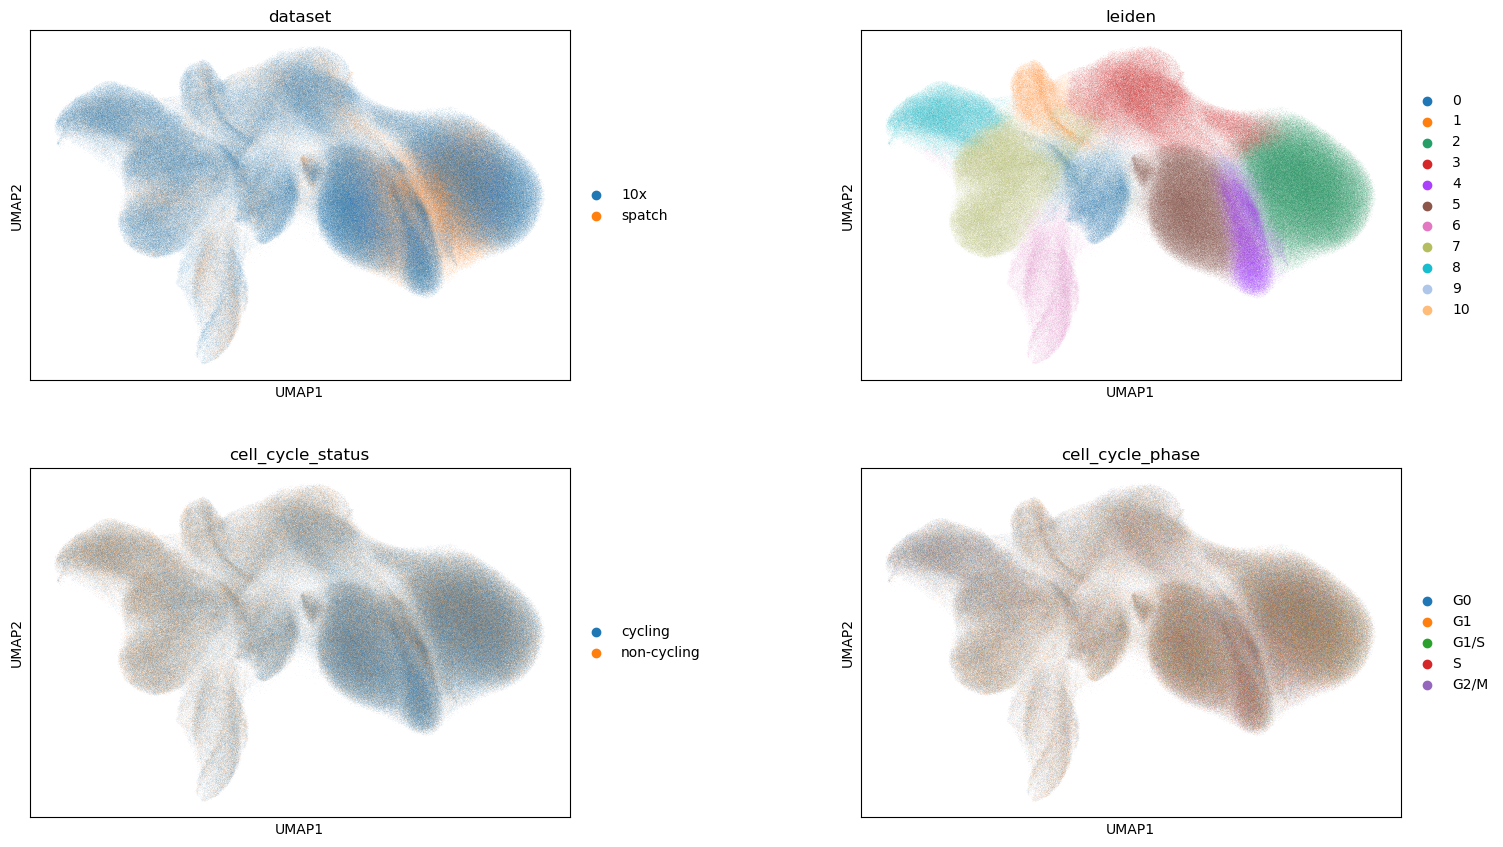

In [32]:
sc.pl.umap(adata, color=['dataset', 'leiden', 'cell_cycle_status', 'cell_cycle_phase'], wspace=0.4, ncols=2)

### Normalize Data and Find Cluster Markers

In [26]:
# Normalize and log-transform for differential expression analysis
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["lognorm"] = adata.X.copy()

In [27]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", layer="lognorm", pts=True)

### Identify and Annotate Cell Types

In [28]:
# Display top marker genes for each cluster
for cluster in adata.obs['leiden'].cat.categories:
    top_genes = sc.get.rank_genes_groups_df(adata, group=cluster).head(30)['names']
    genes_list = ",".join(top_genes)
    print(f"Cluster {cluster}: {genes_list}")

Cluster 0: CD3E,IL2RG,IL2RB,SEMA4D,CD247,ITGAL,ACAP1,ADGRE5,ZAP70,CXCR3,CD44,TNFRSF18,GZMA,CD96,CD7,GBP5,RASGRP1,IKZF3,SELPLG,ITGB2,PTK2B,JAK3,CD2,PIK3CD,SH2D2A,LAG3,TNFRSF1B,CARD11,TIGIT,GZMB
Cluster 1: MZB1,XBP1,DERL3,TENT5C,CD79A,POU2AF1,CD38,PIM2,SLAMF7,SEL1L,MAN1A1,PDK1,IRF4,FCRL5,CYBA,KCNA3,FKBP11,CCR2,PECAM1,CD27,PRDM1,NCF1,PTK2B,GLCCI1,IKZF3,ICAM3,TNFRSF17,STAT1,ZBP1,CLPTM1L
Cluster 2: EEF1G,EPCAM,IRAK1,ITGB4,OGT,PTPRF,ADAMTS1,DHCR24,NPR1,MUC1,MUC16,DEPTOR,IMPDH2,BCL11A,DDR1,CELSR1,EHF,AR,NORAD,DAG1,CFB,PVT1,TBRG4,MSLN,CCT6A,S100A1,HSPD1,PABPC1L,MEIS1,PDHA1
Cluster 3: ITGB2,CD14,CD4,SIGLEC1,GRN,SLCO2B1,CTSL,CYBB,CSF1R,MSR1,CD68,STAB1,TYMP,FCGR2A,MMP9,ITGAX,PLAUR,CD163,ADAM8,GAA,SLC7A7,CTSH,MAN2B1,HCK,FCGR3A,AXL,SPI1,CYBA,MAFB,TREM2
Cluster 4: PPP1R1B,KLK6,LDHA,EIF4A1,S100A1,RAN,ITGA3,FBL,TFAP2A,LRATD2,GPRC5C,SNRPB,ITGB3,IGFBP2,PDIA4,BCAM,MUC1,DDR1,DOK7,IFITM1,TMEM100,EPCAM,ALDOA,CD47,KLK10,SPON1,VEGFA,PKM,CDH1,KCNH3
Cluster 5: CD47,LAPTM4B,EPCAM,BCAM,CP,CFB,SNRPB,IGFBP2,EIF4A1,

### Define Cell Type Annotations and Colors

In [29]:
# Cell type mapping with ordered categories
cell_type_config = {
    'mapping': {
        "0": "T cells",
        "1": "Plasma cells",
        "2": "Tumor (1)",
        "3": "Macrophages (M1-like)",
        "4": "Tumor (2)",
        "5": "Tumor (3)",
        "6": "Endothelial",
        "7": "CAFs",
        "8": "Fibroblasts",
        "9": "Unassigned",
        "10": "Macrophages (M2-like)"
    },
    'order': [
        "Tumor (1)", "Tumor (2)", "Tumor (3)",
        "T cells", "Plasma cells", 
        "Macrophages (M1-like)", "Macrophages (M2-like)",
        "CAFs", "Fibroblasts",
        "Endothelial",
        "Unassigned"
    ],
    'colors': {
        "Tumor (1)": "#e31a1c",
        "Tumor (2)": "#fb9a99",
        "Tumor (3)": "#a50f15",
        "T cells": "#1f78b4",
        "Plasma cells": "#00ced1",
        "Macrophages (M1-like)": "#cab2d6",
        "Macrophages (M2-like)": "#542788",
        "CAFs": "#33a02c",
        "Fibroblasts": "#b2df8a",
        "Endothelial": "#fdbf6f",
        "Unassigned": "#bdbdbd"
    }
}

# Apply annotations
adata.obs['cell_type'] = adata.obs['leiden'].astype(str).map(cell_type_config['mapping'])

# Convert to categorical with proper ordering
# Only include categories that actually exist in the data
existing_categories = adata.obs['cell_type'].unique()
ordered_existing = [cat for cat in cell_type_config['order'] if cat in existing_categories]

adata.obs['cell_type'] = pd.Categorical(
    adata.obs['cell_type'],
    categories=ordered_existing,
    ordered=True
)

# Apply colors (only for existing categories)
adata.uns['cell_type_colors'] = [
    cell_type_config['colors'][cat] 
    for cat in adata.obs['cell_type'].cat.categories
]


### Save Processed Data

In [31]:
adata.write_h5ad(os.path.join(path, 'xenium_ovary_both_processed.h5ad'))

In [ ]:
#save df_rhythmic as pickle
df_rhythmic.to_pickle(os.path.join(path, 'df_rhythmic.pkl'))